In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from model_simple_conv import ConvNet

DIR_PATH = os.getcwd() + '/../'

In [2]:
demo_data = np.load(DIR_PATH + 'data/demos_reach_object_no_distractors_227_16x16.npz')
for k in demo_data.keys():
    print(k, demo_data[k].shape, demo_data[k].dtype)

demo_image_sequences (28763, 16, 16, 3) float32
demo_action_sequences (28763, 3) float64
step_marker (227,) int64


In [3]:
n_traj = 50
n_train = int(0.8 * n_traj)
n_val = n_traj - n_train
idx_train = demo_data['step_marker'][n_train-1]
idx_val = demo_data['step_marker'][n_traj-1]

train_imgs = demo_data['demo_image_sequences'][:idx_train]
train_act = demo_data['demo_action_sequences'][:idx_train]
val_imgs = demo_data['demo_image_sequences'][idx_train:idx_val]
val_acts = demo_data['demo_action_sequences'][idx_train:idx_val]
train_imgs.shape, train_act.shape

((5197, 16, 16, 3), (5197, 3))

In [4]:
def mask_imgs(imgs):
    new_imgs = imgs.copy()
    mask_size = 5
    for im in new_imgs:
        mask_pos = np.random.randint(0, 16-mask_size+1, 2)
        im[mask_pos[0]:mask_pos[0]+5, mask_pos[1]:mask_pos[1]+5] = 0
    return new_imgs

masked1 = mask_imgs(train_imgs)
masked2 = mask_imgs(train_imgs)

train_x = np.concatenate([train_imgs, masked1, masked2])
train_y = np.concatenate([train_act, train_act, train_act])

val_x = val_imgs
val_y = val_acts

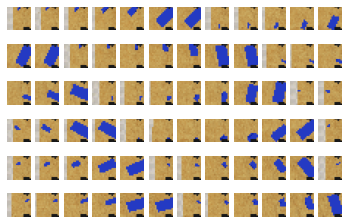

In [78]:
%matplotlib inline
for i, img_idx in enumerate(np.arange(10, 1450, 20)):
    plt.subplot(6, 12, i+1)
    plt.imshow(train_imgs[img_idx])
    plt.axis('off')

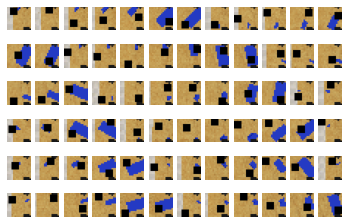

In [75]:
%matplotlib inline
for i, img_idx in enumerate(np.arange(10, 1450, 20)):
    plt.subplot(6, 12, i+1)
    plt.imshow(masked1[img_idx])
    plt.axis('off')

In [6]:
def normalize(x_data, y_data):
    normal_x = x_data
    normal_y = y_data * 200
    return normal_x, normal_y

normal_train_x, normal_train_y = normalize(train_x, train_y)
normal_val_x, normal_val_y = normalize(val_x, val_y)

In [7]:
for i in range(3):
    print(normal_train_x[:,:,:,i].min(), normal_train_x[:,:,:,i].max())
    
for i in range(3):
    print(normal_train_y[:,i].min(), normal_train_y[:,i].max())

0.0 0.85490197
0.0 0.8352941
0.0 0.8156863
-0.5798661897404465 0.8738841782665044
-0.973966396078829 0.9320732321051899
-0.9881260560467855 0.2841472625732422


In [11]:
class DemoDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.x = torch.as_tensor(data_x, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.as_tensor(data_y, dtype=torch.float32)[:, :3]
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_set = DemoDataset(normal_train_x, normal_train_y)
v_set = DemoDataset(normal_val_x, normal_val_y)

train_set.x.shape, train_set.y.shape, v_set.x.shape, v_set.y.shape

(torch.Size([15591, 3, 16, 16]),
 torch.Size([15591, 3]),
 torch.Size([1254, 3, 16, 16]),
 torch.Size([1254, 3]))

In [12]:
model = ConvNet(n_classes=3)
#model = MLP(layers_dim=(16*16*3, 16, 3))
print('MODEL INFO:', model, sep='\n')

MODEL INFO:
ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=16, out_features=3, bias=True)
  )
)


In [22]:
def train(model, train_set, v_set, n_epochs, lr, bs):
    train_loader = DataLoader(train_set, batch_size=bs, shuffle=True, drop_last=True)
    v_loader = DataLoader(v_set, batch_size=64, shuffle=False, drop_last=False)
    #device = torch.device('cpu')
    #model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    loss_logger = {'loss':[], 'vloss':[], 'loss_class':[], 'vloss_class':[]}

    for epoch in range(n_epochs):
        print(f"Starting epoch {epoch}/{n_epochs}", end=" ")
        for batch, (x, y) in enumerate(train_loader):
            model.train()
            #x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model.forward(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            if batch % 100 == 0:
                model.eval()
                with torch.no_grad():
                    loss_logger['loss'].append(loss.item())
                    loss_per_class = ((y - y_pred)**2).mean(axis=0).numpy()
                    loss_logger['loss_class'].append(loss_per_class)
                    x_val, y_val = v_loader.dataset.x, v_loader.dataset.y
                    y_pred = model.forward(x_val)
                    v_loss_per_class = ((y_val - y_pred)**2).mean(axis=0).numpy()
                    v_loss = v_loss_per_class.mean().item()
                    loss_logger['vloss'].append(v_loss)
                    loss_logger['vloss_class'].append(v_loss_per_class)
            if batch % 100 == 0:
                print('vloss', loss.item())
    return loss_logger



In [23]:
model = ConvNet(n_classes=3)
loss_log = train(model, train_set, v_set, n_epochs=100, lr=0.0001, bs=256)

Starting epoch 0/100 vloss 0.39535772800445557
Starting epoch 1/100 vloss 0.11563342809677124
Starting epoch 2/100 vloss 0.07383357733488083
Starting epoch 3/100 vloss 0.030185377225279808
Starting epoch 4/100 vloss 0.02730829082429409
Starting epoch 5/100 vloss 0.020308347418904305
Starting epoch 6/100 vloss 0.013969971798360348
Starting epoch 7/100 vloss 0.016876138746738434
Starting epoch 8/100 vloss 0.01076405867934227
Starting epoch 9/100 vloss 0.0083161611109972
Starting epoch 10/100 vloss 0.007601229008287191
Starting epoch 11/100 vloss 0.011012987233698368
Starting epoch 12/100 vloss 0.012394014745950699
Starting epoch 13/100 vloss 0.012950324453413486
Starting epoch 14/100 vloss 0.008813277818262577
Starting epoch 15/100 vloss 0.009337020106613636
Starting epoch 16/100 vloss 0.006568348500877619
Starting epoch 17/100 vloss 0.008010764606297016
Starting epoch 18/100 vloss 0.005683533381670713
Starting epoch 19/100 vloss 0.009413148276507854
Starting epoch 20/100 vloss 0.0084740

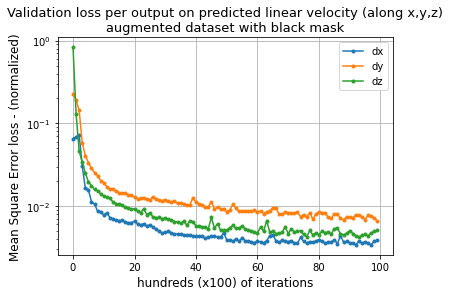

In [93]:
plt.plot(np.stack(loss_log['vloss_class']), '.-')
plt.yscale('log')
#plt.plot(loss_log['loss'], '.-', label='Validation loss')
plt.title("Validation loss per output on predicted linear velocity (along x,y,z)\naugmented dataset with black mask", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundreds (x100) of iterations", fontsize=12)
plt.legend(('dx', 'dy', 'dz'))
plt.grid()

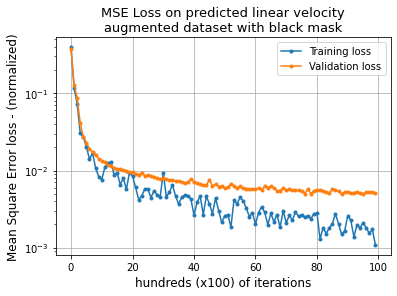

In [94]:
plt.plot(loss_log['loss'], '.-', label='Training loss')
plt.plot(loss_log['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted linear velocity\naugmented dataset with black mask", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundreds (x100) of iterations", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()

In [26]:
torch.save(model.state_dict(), DIR_PATH + '/data/model_conv_simple_100ep_50_16x16_mask5x5_v_xyz.pth')

In [27]:
loss_log2 = train(model, train_set, v_set, n_epochs=100, lr=0.000001, bs=256)

Starting epoch 0/100 vloss 0.001793750561773777
Starting epoch 1/100 vloss 0.0015320581151172519
Starting epoch 2/100 vloss 0.0010418338933959603
Starting epoch 3/100 vloss 0.0014600249705836177
Starting epoch 4/100 vloss 0.001935905427671969
Starting epoch 5/100 vloss 0.0014906803844496608
Starting epoch 6/100 vloss 0.0015694801695644855
Starting epoch 7/100 vloss 0.0009527709917165339
Starting epoch 8/100 vloss 0.001360985916107893
Starting epoch 9/100 vloss 0.002140719210729003
Starting epoch 10/100 vloss 0.0017441143281757832
Starting epoch 11/100 vloss 0.0010749396169558167
Starting epoch 12/100 vloss 0.0019036238081753254
Starting epoch 13/100 vloss 0.0016842433251440525
Starting epoch 14/100 vloss 0.0017658458091318607
Starting epoch 15/100 vloss 0.001609841943718493
Starting epoch 16/100 vloss 0.0012018801644444466
Starting epoch 17/100 vloss 0.0014155032113194466
Starting epoch 18/100 vloss 0.0014100180706009269
Starting epoch 19/100 vloss 0.0022631098981946707
Starting epoch 

In [28]:
plt.plot(loss_log2['loss'], '.-', label='Training loss')
plt.plot(loss_log2['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("number of iterations", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()

{'loss': [0.001793750561773777,
  0.0015320581151172519,
  0.0010418338933959603,
  0.0014600249705836177,
  0.001935905427671969,
  0.0014906803844496608,
  0.0015694801695644855,
  0.0009527709917165339,
  0.001360985916107893,
  0.002140719210729003,
  0.0017441143281757832,
  0.0010749396169558167,
  0.0019036238081753254,
  0.0016842433251440525,
  0.0017658458091318607,
  0.001609841943718493,
  0.0012018801644444466,
  0.0014155032113194466,
  0.0014100180706009269,
  0.0022631098981946707,
  0.002136577619239688,
  0.002163921482861042,
  0.001270182547159493,
  0.0011121287243440747,
  0.001132398727349937,
  0.0015542347682639956,
  0.0013297341065481305,
  0.0012512755347415805,
  0.0010872194543480873,
  0.0010764370672404766,
  0.0010807079961523414,
  0.0011795194586738944,
  0.001240202342160046,
  0.0013623759150505066,
  0.0027512505184859037,
  0.0012995828874409199,
  0.0013015512377023697,
  0.001553389709442854,
  0.002027802634984255,
  0.0015548485098406672,
  0.

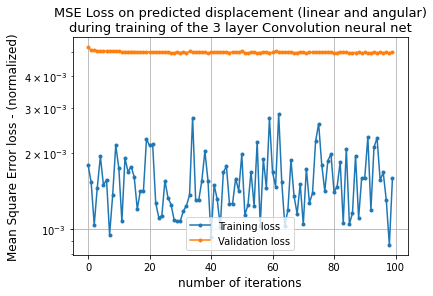

In [30]:
plt.plot(loss_log2['loss'], '.-', label='Training loss')
plt.plot(loss_log2['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("number of iterations", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()

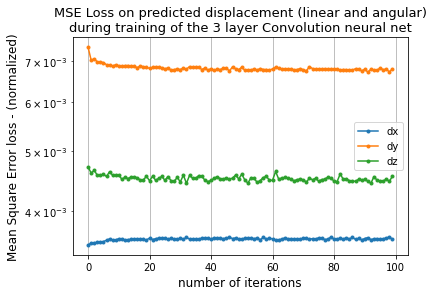

In [31]:
plt.plot(np.stack(loss_log2['vloss_class']), '.-')
plt.yscale('log')
#plt.plot(loss_log['loss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted displacement (linear and angular)\nduring training of the 3 layer Convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("number of iterations", fontsize=12)
plt.legend(('dx', 'dy', 'dz'))
plt.grid()

In [79]:
nomask_train_x = np.concatenate([train_imgs, train_imgs, train_imgs])

In [80]:
nomask_train_set = DemoDataset(nomask_train_x, normal_train_y)

In [82]:
model = ConvNet(n_classes=3)
nomask_loss_log = train(model, nomask_train_set, v_set, n_epochs=100, lr=0.0001, bs=256)

Starting epoch 0/100 vloss 0.224053755402565
Starting epoch 1/100 vloss 0.08726359158754349
Starting epoch 2/100 vloss 0.0283491313457489
Starting epoch 3/100 vloss 0.01537361741065979
Starting epoch 4/100 vloss 0.012240663170814514
Starting epoch 5/100 vloss 0.011377613991498947
Starting epoch 6/100 vloss 0.012672674842178822
Starting epoch 7/100 vloss 0.006327333394438028
Starting epoch 8/100 vloss 0.0048798550851643085
Starting epoch 9/100 vloss 0.006255369167774916
Starting epoch 10/100 vloss 0.0069386824034154415
Starting epoch 11/100 vloss 0.005413082893937826
Starting epoch 12/100 vloss 0.00549802603200078
Starting epoch 13/100 vloss 0.007546186912804842
Starting epoch 14/100 vloss 0.003467262489721179
Starting epoch 15/100 vloss 0.00531826913356781
Starting epoch 16/100 vloss 0.0041323392651975155
Starting epoch 17/100 vloss 0.0025460964534431696
Starting epoch 18/100 vloss 0.003186318324878812
Starting epoch 19/100 vloss 0.004405108746141195
Starting epoch 20/100 vloss 0.00327

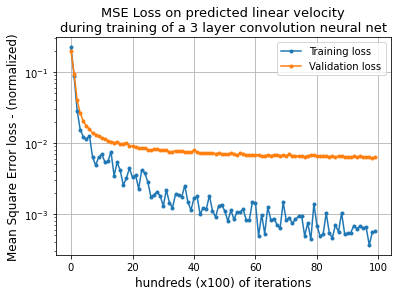

In [90]:
plt.plot(nomask_loss_log['loss'], '.-', label='Training loss')
plt.plot(nomask_loss_log['vloss'], '.-', label='Validation loss')
plt.title("MSE Loss on predicted linear velocity\nduring training of a 3 layer convolution neural net", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundreds (x100) of iterations", fontsize=12)
plt.yscale('log')
plt.legend()
plt.grid()

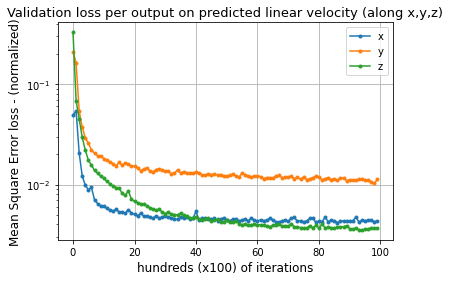

In [92]:
plt.plot(np.stack(nomask_loss_log['vloss_class']), '.-')
plt.yscale('log')
#plt.plot(loss_log['loss'], '.-', label='Validation loss')
plt.title("Validation loss per output on predicted linear velocity (along x,y,z)", fontsize=13)
plt.ylabel("Mean Square Error loss - (normalized)", fontsize=12)
plt.xlabel("hundreds (x100) of iterations", fontsize=12)
plt.legend(('x', 'y', 'z'))
plt.grid()

In [85]:
torch.save(model.state_dict(), DIR_PATH + '/data/model_conv_simple_100ep_50_16x16_nomask_v_xyz.pth')